# Esercizio Assicurazione Sanitaria

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, classification_report
from sklearn.neighbors import KNeighborsClassifier

df = pd.read_csv(r'C:\Users\simon\Desktop\Università\Esami terzo anno\Data Analytics\Esercizi\EsercizioEsame\Esercitazioni per esame\Assicurazione Sanitaria\dataset_csv\train_jRxnrHD.csv')
df.head

<bound method NDFrame.head of            id  perc_premium_paid_by_cash_credit  age_in_days  Income  \
0      110936                             0.429        12058  355060   
1       41492                             0.010        21546  315150   
2       31300                             0.917        17531   84140   
3       19415                             0.049        15341  250510   
4       99379                             0.052        31400  198680   
...       ...                               ...          ...     ...   
79848   48057                             0.425        23367  224550   
79849   59012                             0.704        19356  279150   
79850   77050                             0.000        23372  305020   
79851   67225                             0.398        22641   39330   
79852   71531                             0.550        15709  280140   

       Count_3-6_months_late  Count_6-12_months_late  \
0                        0.0                     

In [2]:
df = df.rename(columns={'no_of_premiums_paid':'n_premiums_paid'})
print(df.dtypes)

id                                    int64
perc_premium_paid_by_cash_credit    float64
age_in_days                           int64
Income                                int64
Count_3-6_months_late               float64
Count_6-12_months_late              float64
Count_more_than_12_months_late      float64
application_underwriting_score      float64
n_premiums_paid                       int64
sourcing_channel                     object
residence_area_type                  object
premium                               int64
target                                int64
dtype: object


## 1) Pre elaborazione dei dati
Noto subito che nella colonna 'application underwriting score' manca qualche valore , 
cotrolliamo anche nelle colonne 'age_in_days' e 'Income' 

In [3]:
df.isna().sum()

id                                     0
perc_premium_paid_by_cash_credit       0
age_in_days                            0
Income                                 0
Count_3-6_months_late                 97
Count_6-12_months_late                97
Count_more_than_12_months_late        97
application_underwriting_score      2974
n_premiums_paid                        0
sourcing_channel                       0
residence_area_type                    0
premium                                0
target                                 0
dtype: int64

Dato che 2974 è circa il 3.7% del totale delle righe decido di droppare queste righe

In [4]:
df = df.dropna(subset=['application_underwriting_score'])
print(df['application_underwriting_score'].isna().sum())
df = df.dropna(subset=['Count_3-6_months_late'])
print(df['Count_3-6_months_late'].isna().sum())
df = df.dropna(subset=['Count_6-12_months_late'])
print(df['Count_6-12_months_late'].isna().sum())
df = df.dropna(subset=['Count_more_than_12_months_late'])
print(df['Count_more_than_12_months_late'].isna().sum())

0
0
0
0


Controlliamo se nelle series "residence_area_type" e "sourcing_channel" ci sia qualche errore di formattazione

In [5]:
print(df['residence_area_type'].unique())
print(df['sourcing_channel'].unique())

['Urban' 'Rural']
['C' 'A' 'B' 'D' 'E']


Procediamo con la gestione dei valori duplicati

In [6]:
print('Gestione valori duplicati ID:\n')
if len(df['id'].unique()) < len(df.index):
    df = df.drop_duplicates('id', keep='first')
    print('Nuovo dataset con righe pari a: ', len(df))
else:
    print('Non sono presenti duplicati. ')

Gestione valori duplicati ID:

Non sono presenti duplicati. 


Controlliamo se sono presenti outliers in "application_underwriting_score":


(array([4.3000e+01, 5.5000e+01, 1.0000e+02, 1.5000e+02, 2.3000e+02,
        5.6600e+02, 1.4690e+03, 5.1750e+03, 2.4176e+04, 4.4891e+04]),
 array([91.9  , 92.699, 93.498, 94.297, 95.096, 95.895, 96.694, 97.493,
        98.292, 99.091, 99.89 ]),
 <BarContainer object of 10 artists>)

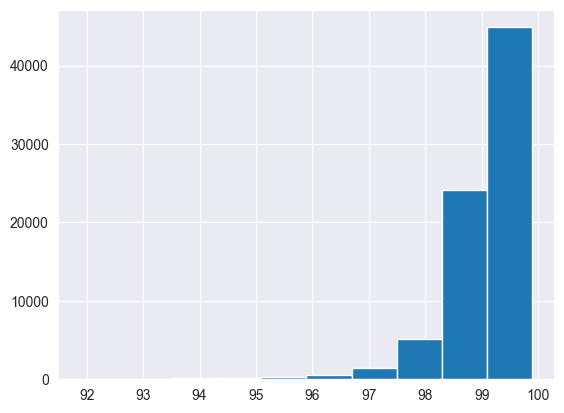

In [7]:
print('Controlliamo se sono presenti outliers in "application_underwriting_score":\n')
plt.hist(df['application_underwriting_score'])

Non sono presenti outliers

## 2) Matrice di correlazione

Andiamo ad individuare gli attributi maggiormente correlati alla variabile target

Per poter creare una matrice di correlazione tra tutti gli attributi dobbiamo prima trasformare gli attributi di tipo stringa in tipo numerico

In [8]:
codes1, uniques1 = pd.factorize(df['sourcing_channel'])
df['sourcing_channel'] = codes1
codes2, uniques2 = pd.factorize(df['residence_area_type'])
df['residence_area_type'] = codes2
print('Prima:\n', uniques1, '\n',uniques2)
print('\nDopo:\n', df['sourcing_channel'].unique(), '\n', df['residence_area_type'].unique())

Prima:
 Index(['C', 'A', 'B', 'D', 'E'], dtype='object') 
 Index(['Urban', 'Rural'], dtype='object')

Dopo:
 [0 1 2 3 4] 
 [0 1]


Matrice di correlazione:


Text(0.5, 1.0, 'Matrice di correlazione')

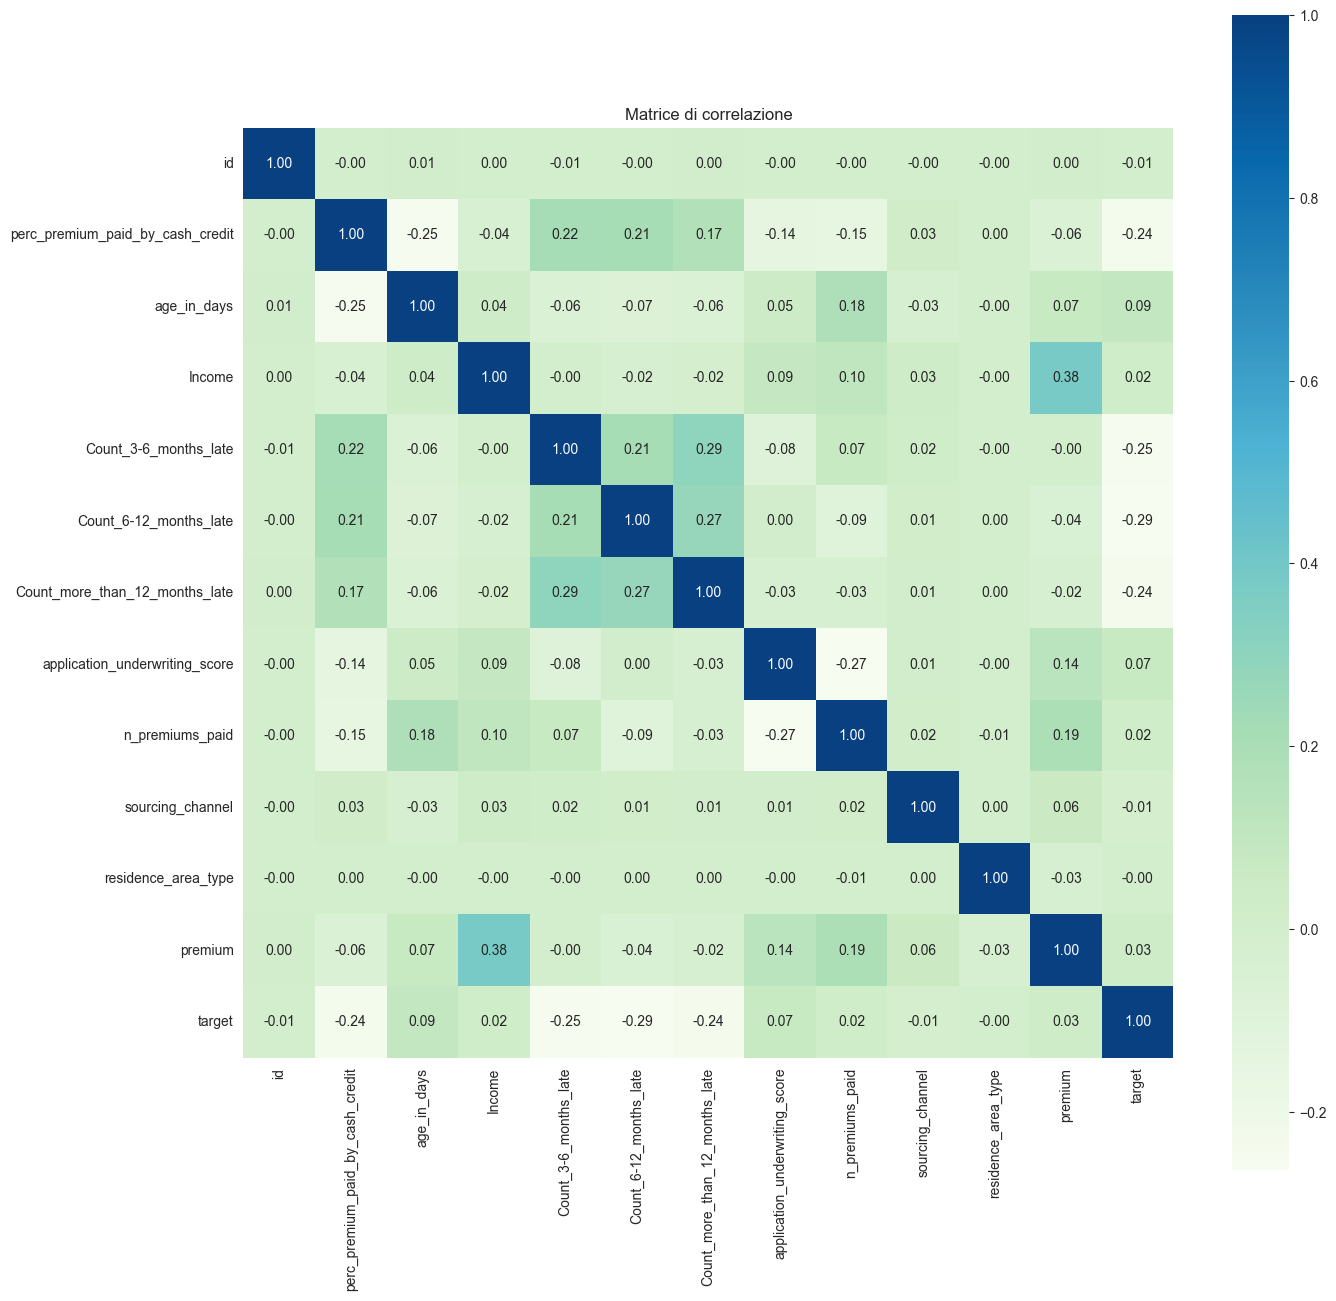

In [9]:
print('Matrice di correlazione:\n')
corr_matrix = df.corr()
plt.figure(figsize=(15,15))
plot = sns.heatmap(corr_matrix, vmax=1, square=True, annot=True, fmt='.2f', cmap='GnBu', robust=True)
plt.title('Matrice di correlazione')

Troviamo quali sono gli attributi maggiormente correlati :

In [10]:
def remove_unrelated(df_model, threshold):
    corr = df_model.corr()
    corr_target = abs(corr['target'])
    relevant_features = corr_target[corr_target > threshold]
    print("Le features maggiormente correlate con valore > di", threshold,"sono:\n")
    print(relevant_features)
    
    rel_feat = relevant_features.keys().tolist()
    new_df = df_model[rel_feat]
    
    return new_df

new_df = remove_unrelated(df, 0.2)

Le features maggiormente correlate con valore > di 0.2 sono:

perc_premium_paid_by_cash_credit    0.236109
Count_3-6_months_late               0.251305
Count_6-12_months_late              0.289165
Count_more_than_12_months_late      0.241386
target                              1.000000
Name: target, dtype: float64


Andiamo a definire ed usare due classificatori

## 3-4) Classificatori e Studio accuratezza


Classificatore 1 - Decision Tree:


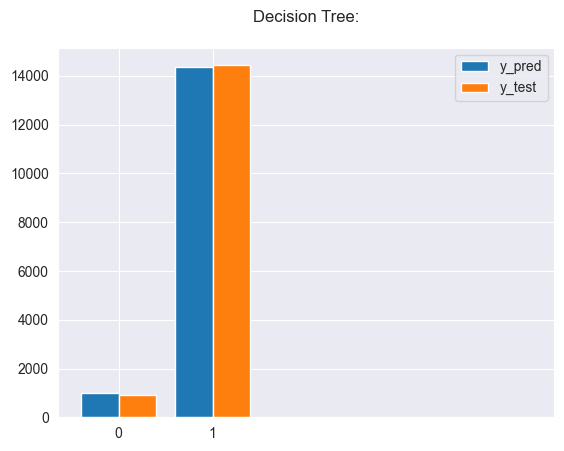

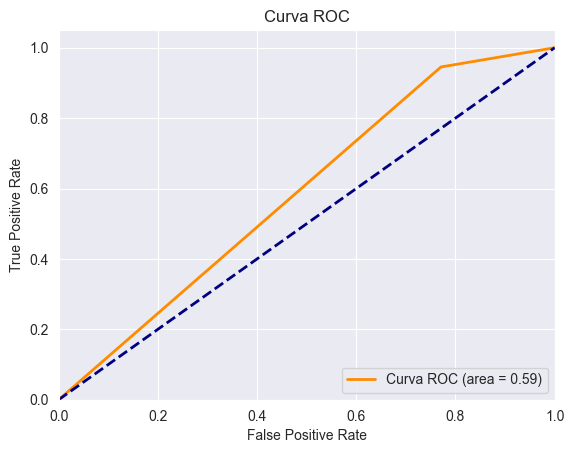

Accuracy: 0.9018281178843276
Precision: 0.581624280832336
Recall: 0.5872354061707079
F_score: 0.5842867546962077
Matrice di confusione:
 [[  214   720]
 [  789 13648]]
              precision    recall  f1-score   support

           0       0.21      0.23      0.22       934
           1       0.95      0.95      0.95     14437

    accuracy                           0.90     15371
   macro avg       0.58      0.59      0.58     15371
weighted avg       0.91      0.90      0.90     15371

Cross accuracy: 0.8975343178713162
Cross precision: 0.5817569228295543
Cross recall: 0.5918210487970892
Cross f_score: 0.5863223472738119

Classificatore 2 - K nearest neighbors:


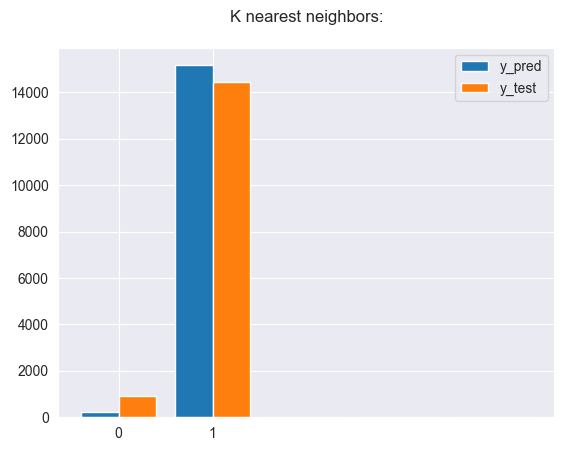

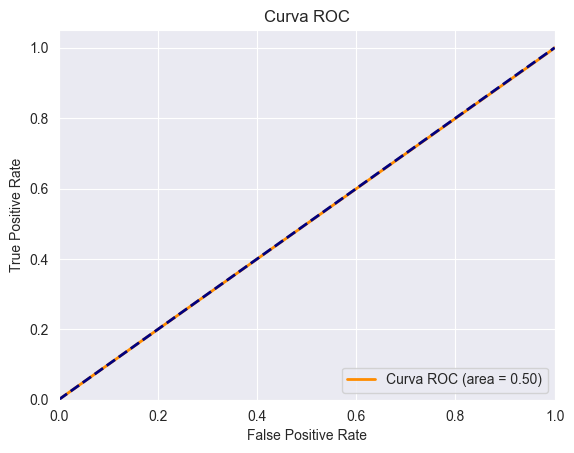

Accuracy: 0.9269403422028495
Precision: 0.49775603084133513
Recall: 0.49946270282504845
F_score: 0.49148927551883587
Matrice di confusione:
 [[   12   922]
 [  201 14236]]
              precision    recall  f1-score   support

           0       0.06      0.01      0.02       934
           1       0.94      0.99      0.96     14437

    accuracy                           0.93     15371
   macro avg       0.50      0.50      0.49     15371
weighted avg       0.89      0.93      0.90     15371

Cross accuracy: 0.9265369852319303
Cross precision: 0.5083628643343654
Cross recall: 0.501805592442786
Cross f_score: 0.4947051225496434


In [11]:
x = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True) 
    
classifiers = [DecisionTreeClassifier(), KNeighborsClassifier(n_neighbors=3)]
names = ['Decision Tree:\n', 'K nearest neighbors:\n']

for idx, (classifier, name) in enumerate(zip(classifiers, names)):
    
    print("\nClassificatore", idx+1, "-", name)
    
    classifier.fit(X_train, y_train)    
    y_pred = classifier.predict(X_test)
    
    
    plt.hist([y_pred, y_test], bins=[0, 1, 2, 3, 4, 5], label=['y_pred', 'y_test'], align='left') #
    plt.xticks([0,1])
    plt.title(name)
    plt.yscale('linear')
    plt.legend()
    plt.show()
    
    
    # Calcolo della curva ROC e dell'AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Disegna la curva ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.show()
    
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    #Eseguo cross-validation per 'migliorare' il classificatore
    scoring = {'precision':'precision_macro', 'recall':'recall_macro', 'f1_score':'f1_macro', 'accuracy':'accuracy'}
    score = cross_validate(classifier, x, y, scoring=scoring)
    cross_precision = score['test_precision'].mean()
    cross_accuracy = score['test_accuracy'].mean()
    cross_f_score = score['test_f1_score'].mean()
    cross_recall = score['test_recall'].mean()
    
    #Stampiamo metriche di valutazione, matrice di confusione e report di classificazione
    print('Accuracy:', accuracy)
    print('Precision:',precision)
    print('Recall:',recall)
    print('F_score:',f1)
    print('Matrice di confusione:\n',confusion)
    print(report)
    
    #Stampiamo le metriche della cross validation
    print('Cross accuracy:',cross_accuracy)
    print('Cross precision:',cross_precision)
    print('Cross recall:',cross_recall)
    print('Cross f_score:',cross_f_score)

Proviamo a riaddestrare e riusare i classificatori sul nuovo dataframe per vedere se le prestazioni sono effettivamente migliori


Classificatore 1 - Decision Tree:


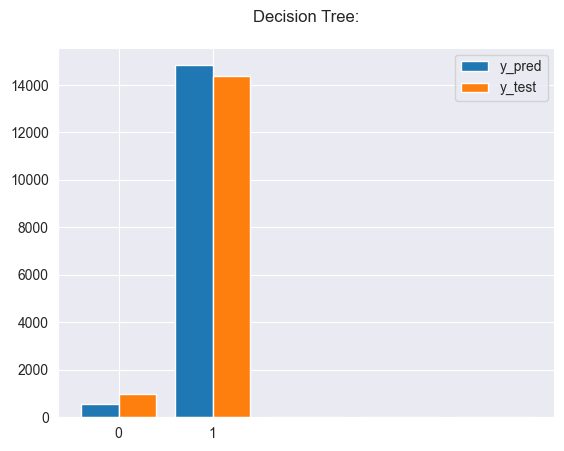

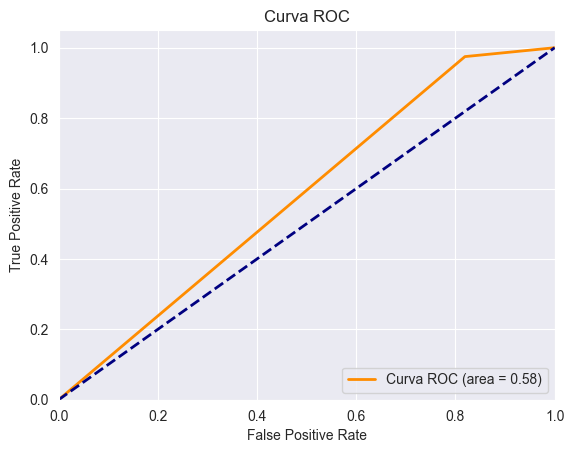

Accuracy: 0.9239476937089324
Precision: 0.6373355203707327
Recall: 0.5778315987615288
F_score: 0.5967158352115908
Matrice di confusione:
 [[  178   806]
 [  363 14024]]
              precision    recall  f1-score   support

           0       0.33      0.18      0.23       984
           1       0.95      0.97      0.96     14387

    accuracy                           0.92     15371
   macro avg       0.64      0.58      0.60     15371
weighted avg       0.91      0.92      0.91     15371

Cross accuracy: 0.9275909179623968
Cross precision: 0.6488338979141623
Cross recall: 0.5836250302959057
Cross f_score: 0.6043962606414596

Classificatore 2 - K nearest neighbors:


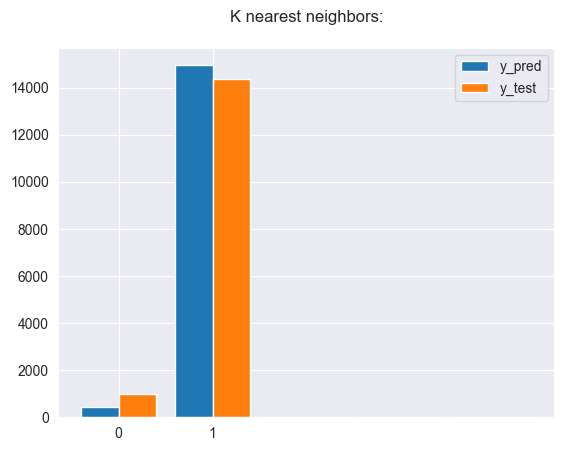

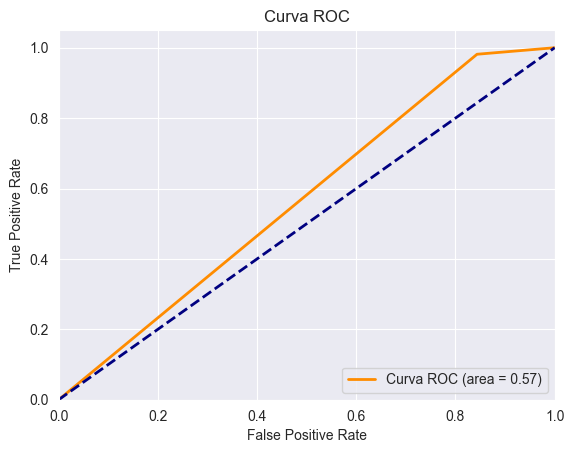

Accuracy: 0.9286318391776722
Precision: 0.6551386649083644
Recall: 0.5689728221220489
F_score: 0.5909120143547246
Matrice di confusione:
 [[  154   830]
 [  267 14120]]
              precision    recall  f1-score   support

           0       0.37      0.16      0.22       984
           1       0.94      0.98      0.96     14387

    accuracy                           0.93     15371
   macro avg       0.66      0.57      0.59     15371
weighted avg       0.91      0.93      0.92     15371

Cross accuracy: 0.9244291197709973
Cross precision: 0.6379544092815855
Cross recall: 0.573833067019623
Cross f_score: 0.5909144679399605


In [12]:
x = new_df.drop('target', axis=1)
y = new_df['target']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True) 
    
classifiers = [DecisionTreeClassifier(), KNeighborsClassifier(n_neighbors=3)]
names = ['Decision Tree:\n', 'K nearest neighbors:\n']

for idx, (classifier, name) in enumerate(zip(classifiers, names)):
    
    print("\nClassificatore", idx+1, "-", name)
    
    classifier.fit(X_train, y_train)    
    y_pred = classifier.predict(X_test)
    
    plt.hist([y_pred, y_test], bins=[0, 1, 2, 3, 4, 5], label=['y_pred', 'y_test'], align='left') #
    plt.xticks([0,1])
    plt.title(name)
    plt.yscale('linear')
    plt.legend()
    plt.show()
    
    # Calcolo della curva ROC e dell'AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Disegna la curva ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.show()
    
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    #Eseguo cross-validation per 'migliorare' il classificatore
    scoring = {'precision':'precision_macro', 'recall':'recall_macro', 'f1_score':'f1_macro', 'accuracy':'accuracy'}
    score = cross_validate(classifier, x, y, scoring=scoring)
    cross_precision = score['test_precision'].mean()
    cross_accuracy = score['test_accuracy'].mean()
    cross_f_score = score['test_f1_score'].mean()
    cross_recall = score['test_recall'].mean()
    
    #Stampiamo metriche di valutazione, matrice di confusione e report di classificazione
    print('Accuracy:', accuracy)
    print('Precision:',precision)
    print('Recall:',recall)
    print('F_score:',f1)
    print('Matrice di confusione:\n',confusion)
    print(report)
    
    #Stampiamo le metriche della cross validation
    print('Cross accuracy:',cross_accuracy)
    print('Cross precision:',cross_precision)
    print('Cross recall:',cross_recall)
    print('Cross f_score:',cross_f_score)